# Imports

In [1]:
import logging
import os

import pandas as pd
import requests

import core.config.config_ as cconconf
import core.finance as cofinanc
import core.finance.bid_ask as cfibiask
import core.finance.resampling as cfinresa
import core.plotting.normality as cplonorm
import dataflow.core as dtfcore
import dataflow.core.utils as dtfcorutil
import dataflow.system.source_nodes as dtfsysonod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.hprint as hprint
import helpers.hsql as hsql
import im_v2.ccxt.data.client as icdcl
import im_v2.im_lib_tasks as imvimlita

/app/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8fa48d19-c4a8-4844-be19-7387e02a71ae.json'


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

# Config

In [3]:
def get_cmtask1704_config_ccxt() -> cconconf.Config:
    """
    Get config, that specifies params for getting raw data.
    """
    config = cconconf.Config()
    # Load parameters.
    config.add_subconfig("load")
    env_file = imvimlita.get_db_env_path("dev")
    connection_params = hsql.get_connection_info_from_env_file(env_file)
    config["load"]["connection"] = hsql.get_connection(*connection_params)
    config["load"]["aws_profile"] = "ck"
    config["load"]["data_dir_hist"] = os.path.join(
        "s3://cryptokaizen-data", "historical"
    )
    config["load"]["data_snapshot"] = "latest"
    config["load"]["partition_mode"] = "by_year_month"
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["vendor"] = "CCXT"
    # Data range for real-time data.
    config["data"]["start_date_rt"] = pd.Timestamp("2022-04-01", tz="UTC")
    config["data"]["end_date_rt"] = pd.Timestamp("2022-04-15", tz="UTC")
    # Data range for historical data.
    config["data"]["start_date_hist"] = pd.Timestamp("2022-01-01", tz="UTC")
    config["data"]["end_date_hist"] = pd.Timestamp("2022-01-15", tz="UTC")
    # Transformation parameters.
    config.add_subconfig("transform")
    config["transform"]["resampling_rule"] = "5T"
    config["transform"]["rets_type"] = "pct_change"
    return config

In [4]:
config = get_cmtask1704_config_ccxt()
print(config)

load:
  connection: <connection object; dsn: 'user=postgres password=xxx dbname=im_data_db host=dev-im-db.cpox8ul7pzan.eu-north-1.rds.amazonaws.com port=5432', closed: 0>
  aws_profile: ck
  data_dir_hist: s3://cryptokaizen-data/historical
  data_snapshot: latest
  partition_mode: by_year_month
data:
  vendor: CCXT
  start_date_rt: 2022-04-01 00:00:00+00:00
  end_date_rt: 2022-04-15 00:00:00+00:00
  start_date_hist: 2022-01-01 00:00:00+00:00
  end_date_hist: 2022-01-15 00:00:00+00:00
transform:
  resampling_rule: 5T
  rets_type: pct_change


# Functions

In [5]:
def calculate_vwap_twap(df: pd.DataFrame, resampling_rule: str) -> pd.DataFrame:
    """
    Resample the data and calculate VWAP, TWAP using DataFlow methods.

    :param df: Raw data
    :param resampling_rule: Desired resampling frequency
    :return: Resampled multiindex DataFrame with computed metrics
    """
    # Configure the node to do the TWAP / VWAP resampling.
    node_resampling_config = {
        "in_col_groups": [
            ("close",),
            ("volume",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "rule": resampling_rule,
            "resampling_groups": [
                ({"close": "close"}, "last", {}),
                (
                    {
                        "close": "twap",
                    },
                    "mean",
                    {},
                ),
                (
                    {
                        "volume": "volume",
                    },
                    "sum",
                    {"min_count": 1},
                ),
            ],
            "vwap_groups": [
                ("close", "volume", "vwap"),
            ],
        },
        "reindex_like_input": False,
        "join_output_with_input": False,
    }
    # Put the data in the DataFlow format (which is multi-index).
    converted_data = dtfcorutil.convert_to_multiindex(df, "full_symbol")
    # Create the node.
    nid = "resample"
    node = dtfcore.GroupedColDfToDfTransformer(
        nid,
        transformer_func=cofinanc.resample_bars,
        **node_resampling_config,
    )
    # Compute the node on the data.
    vwap_twap = node.fit(converted_data)
    # Save the result.
    vwap_twap_df = vwap_twap["df_out"]
    return vwap_twap_df

In [6]:
def calculate_returns(df: pd.DataFrame, rets_type: str) -> pd.DataFrame:
    """
    Compute returns on the resampled data DataFlow-style.

    :param df: Resampled multiindex DataFrame
    :param rets_type: i.e., "log_rets" or "pct_change"
    :return: The same DataFrame but with attached columns with returns
    """
    # Configure the node to calculate the returns.
    node_returns_config = {
        "in_col_groups": [
            ("close",),
            ("vwap",),
            ("twap",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "mode": rets_type,
        },
        "col_mapping": {
            "close": "close.ret_0",
            "vwap": "vwap.ret_0",
            "twap": "twap.ret_0",
        },
    }
    # Create the node that computes ret_0.
    nid = "ret0"
    node = dtfcore.GroupedColDfToDfTransformer(
        nid,
        transformer_func=cofinanc.compute_ret_0,
        **node_returns_config,
    )
    # Compute the node on the data.
    rets = node.fit(df)
    # Save the result.
    rets_df = rets["df_out"]
    return rets_df

# Load the data

## CCXT

### Real-time

In [7]:
# Specify params.
vendor = config["data"]["vendor"]
universe_version = "v3"
resample_1min = True
table_name = "ccxt_ohlcv"
connection = config["load"]["connection"]
# Initiate the client.
ccxt_rt_client = icdcl.CcxtSqlRealTimeImClient(
    resample_1min, connection, table_name
)

INFO  txt_tmp=
{
  "CCXT": {
    "binance": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT"
    ],
    "ftx": [
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "gateio": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "kucoin": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ]
  }
}



#### Universe

In [8]:
# Specify the universe.
rt_universe_ccxt = ccxt_rt_client.get_universe()
len(rt_universe_ccxt)

INFO  txt_tmp=
{
  "CCXT": {
    "binance": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT"
    ],
    "ftx": [
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "gateio": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "kucoin": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ]
  }
}



38

In [9]:
# Choose cc for analysis.
full_symbols = rt_universe_ccxt[2:4]
full_symbols

['binance::BNB_USDT', 'binance::BTC_USDT']

#### Data Loader

In [10]:
# Specify time period.
start_date = config["data"]["start_date_rt"]
end_date = config["data"]["end_date_rt"]

# Load the data.
data_rt_ccxt = ccxt_rt_client.read_data(full_symbols, start_date, end_date)
display(data_rt_ccxt.shape)
display(data_rt_ccxt.head(3))

/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(40322, 6)

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-04-01 00:00:00+00:00,binance::BNB_USDT,428.90,429.80,428.5,428.80,1719.66900
2022-04-01 00:00:00+00:00,binance::BTC_USDT,45510.35,45565.29,45445.0,45465.25,83.54849
2022-04-01 00:01:00+00:00,binance::BNB_USDT,428.60,428.80,426.0,426.30,3698.57400


### Historical

In [13]:
# Specify params.
universe_version = "v3"
resample_1min = True
root_dir = config["load"]["data_dir_hist"]
partition_mode = config["load"]["partition_mode"]
data_snapshot = config["load"]["data_snapshot"]
aws_profile = config["load"]["aws_profile"]

# Initiate the client.
historical_client_ccxt = icdcl.CcxtHistoricalPqByTileClient(
    universe_version,
    resample_1min,
    root_dir,
    partition_mode,
    data_snapshot=data_snapshot,
    aws_profile=aws_profile,
)

INFO  txt_tmp=
{
  "CCXT": {
    "binance": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT"
    ],
    "ftx": [
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "gateio": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "kucoin": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ]
  }
}



#### Universe

In [14]:
# Specify the universe.
historical_universe = historical_client_ccxt.get_universe()
# Choose cc for analysis.
full_symbols = historical_universe[2:4]
full_symbols

INFO  txt_tmp=
{
  "CCXT": {
    "binance": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT"
    ],
    "ftx": [
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "ETH_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "gateio": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ],
    "kucoin": [
      "ADA_USDT",
      "AVAX_USDT",
      "BNB_USDT",
      "BTC_USDT",
      "DOGE_USDT",
      "EOS_USDT",
      "ETH_USDT",
      "FIL_USDT",
      "LINK_USDT",
      "SOL_USDT",
      "XRP_USDT"
    ]
  }
}



38

#### Data Loader

In [16]:
# Specify time period.
start_date = config["data"]["start_date_hist"]
end_date = config["data"]["end_date_hist"]

# Load the data.
data_hist_ccxt = historical_client_ccxt.read_data(
    full_symbols, start_date, end_date
)
display(data_hist_ccxt.shape)
display(data_hist_ccxt.head(3))

(40322, 6)

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-01-01 00:00:00+00:00,binance::BNB_USDT,511.50,512.50,511.40,512.2,423.92200
2022-01-01 00:00:00+00:00,binance::BTC_USDT,46216.93,46271.08,46208.37,46250.0,40.57574
2022-01-01 00:01:00+00:00,binance::BNB_USDT,512.20,513.30,511.70,513.1,709.69000


# Calculate VWAP, TWAP and returns in `Dataflow` style

## CCXT

In [34]:
# VWAP, TWAP transformation.
resampling_rule = config["transform"]["resampling_rule"]
vwap_twap_df = calculate_vwap_twap(data_hist_ccxt, resampling_rule)

# Returns calculation.
rets_type = config["transform"]["rets_type"]
vwap_twap_rets_df = calculate_returns(vwap_twap_df, rets_type)

In [35]:
# Show the snippet.
vwap_twap_rets_df.head(3)

close.ret_0                          twap.ret_0                          vwap.ret_0                               close                                twap                              volume                                vwap                  
                          binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT
timestamp                                                                                                                                                                                                                                                                            
2022-01-01 00:00:00+00:00               NaN               NaN               NaN               NaN               NaN               NaN             512.2          46250.00            512.20         46250.000           423.922          40.57574        512.200000      46250.000000
2022-01-01 00:05:00+00:00          0.002733          0.004022          0.001952          0.002248          0.001984          0.002316             513.6          46436.03            513.20         46353.988          2393.343         180.96666        513.216045      46357.134946
2022-01-01 00:10:00+00:00          0.000000         -0.001211          0.000624          0.001380          0.000720          0.001692             513.6          46379.80            513.52         46417.962          1433.895          98.22629        513.585325      46435.585278

,close.ret_0,twap.ret_0,vwap.ret_0
close.ret_0,1.000000,0.721488,0.812338
twap.ret_0,0.721488,1.000000,0.948830
vwap.ret_0,0.812338,0.948830,1.000000


<AxesSubplot:xlabel='timestamp'>

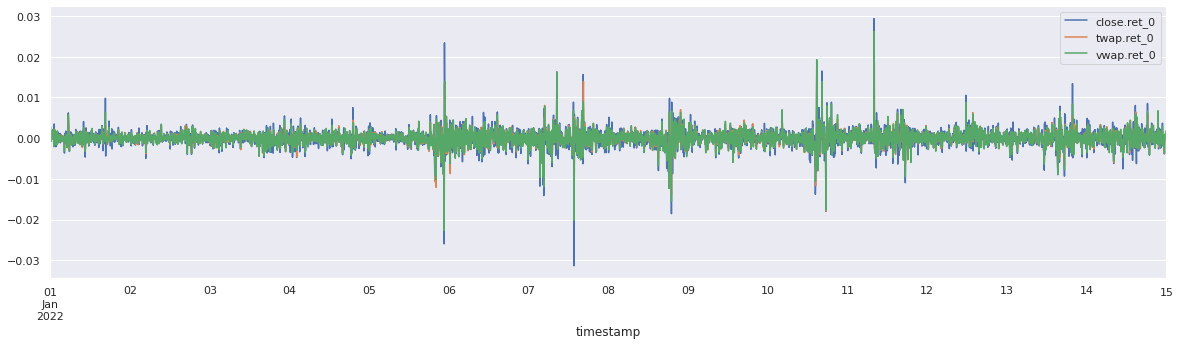

In [36]:
# Stats and vizualisation to check the outcomes.
bnb_ex = vwap_twap_rets_df.swaplevel(axis=1)
bnb_ex = bnb_ex["binance::BNB_USDT"][["close.ret_0", "twap.ret_0", "vwap.ret_0"]]
display(bnb_ex.corr())
bnb_ex.plot()

# Bid-ask data

In [40]:
# TODO(Max): Refactor the loading part once #1766 is implemented.

In [41]:
# Functions to deal with `crypto-chassis` data.
def load_bid_ask_data(exchange_id, currency_pair, list_of_dates):
    # Using the variables from `datelist` the multiple requests can be sent to the API.
    result = []
    for date in list_of_dates:
        # Interaction with the API.
        r = requests.get(
            f"https://api.cryptochassis.com/v1/market-depth/{exchange_id}/{currency_pair}?startTime={date}"
        )
        data = pd.read_csv(r.json()["urls"][0]["url"], compression="gzip")
        # Attaching it day-by-day to the final DataFrame.
        result.append(data)
    bid_ask_df = pd.concat(result)
    return bid_ask_df


def clean_up_raw_bid_ask_data(df, full_symbol):
    # Split the columns to differentiate between `price` and `size`.
    df[["bid_price", "bid_size"]] = df["bid_price_bid_size"].str.split(
        "_", expand=True
    )
    df[["ask_price", "ask_size"]] = df["ask_price_ask_size"].str.split(
        "_", expand=True
    )
    df = df.drop(columns=["bid_price_bid_size", "ask_price_ask_size"])
    # Convert `timestamps` to the usual format.
    df = df.rename(columns={"time_seconds": "timestamp"})
    df["timestamp"] = df["timestamp"].apply(
        lambda x: hdateti.convert_unix_epoch_to_timestamp(x, unit="s")
    )
    df = df.set_index("timestamp")
    # Convert to `float`.
    for cols in df.columns:
        df[cols] = df[cols].astype(float)
    # Add `full_symbol` (hardcoded solution).
    df["full_symbol"] = full_symbol
    return df


def resample_bid_ask(df, resampling_rule):
    """
    In the current format the data is presented in the `seconds` frequency. In
    order to convert it to the minutely (or other) frequencies the following
    aggregation rules are applied:

    - Size is the sum of all sizes during the resampling period
    - Price is the mean of all prices during the resampling period
    """
    new_df = cfinresa.resample(df, rule=resampling_rule).agg(
        {
            "bid_price": "mean",
            "bid_size": "sum",
            "ask_price": "mean",
            "ask_size": "sum",
            "full_symbol": "last",
        }
    )
    return new_df


def process_bid_ask_data(df, full_symbol, resampling_rule):
    # Convert the data to the right format.
    converted_df = clean_up_raw_bid_ask_data(df, full_symbol)
    # Resample.
    converted_resampled_df = resample_bid_ask(converted_df, resampling_rule)
    # Convert to multiindex.
    converted_resampled_df = dtfcorutil.convert_to_multiindex(
        converted_resampled_df, "full_symbol"
    )
    return converted_resampled_df


def calculate_bid_ask_statistics(df):
    # Configure the node to calculate the returns.
    node_bid_ask_config = {
        "in_col_groups": [
            ("ask_price",),
            ("ask_size",),
            ("bid_price",),
            ("bid_size",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "bid_col": "bid_price",
            "ask_col": "ask_price",
            "bid_volume_col": "bid_size",
            "ask_volume_col": "ask_size",
        },
    }
    # Create the node that computes bid ask metrics.
    nid = "process_bid_ask"
    node = dtfcore.GroupedColDfToDfTransformer(
        nid,
        transformer_func=cfibiask.process_bid_ask,
        **node_bid_ask_config,
    )
    # Compute the node on the data.
    bid_ask_metrics = node.fit(df)
    # Save the result.
    bid_ask_metrics = bid_ask_metrics["df_out"]
    return bid_ask_metrics

## Load, process and calculate metrics for raw bid ask data from crypto-chassis

In [42]:
# Get the list of all dates in the range.
datelist = pd.date_range("2022-01-01", periods=14).tolist()
datelist = [str(x.strftime("%Y-%m-%d")) for x in datelist]

In [43]:
# These `full_symbols` need to be loaded (to attach it to historical CCXT data).
full_symbols

['binance::BNB_USDT', 'binance::BTC_USDT']

In [44]:
# Load `binance::BNB_USDT`.
bid_ask_bnb = load_bid_ask_data("binance", "bnb-usdt", datelist)
# Transforming the data. Data is resampled during its transformation.
processed_bid_ask_bnb = process_bid_ask_data(
    bid_ask_bnb, "binance::BNB_USDT", "5T"
)

In [45]:
# Load `binance::BTC_USDT`.
bid_ask_btc = load_bid_ask_data("binance", "btc-usdt", datelist)
# Transforming the data. Data is resampled during its transformation.
processed_bid_ask_btc = process_bid_ask_data(
    bid_ask_btc, "binance::BTC_USDT", "5T"
)

In [46]:
# Unite two `full_symbols`.
bid_ask_df = pd.concat([processed_bid_ask_bnb, processed_bid_ask_btc], axis=1)
# Calculate bid-ask metrics.
bid_ask_df = calculate_bid_ask_statistics(bid_ask_df)
bid_ask_df.tail(3)

ask_value                           bid_value                   centered_order_book_imbalance                       geometric_mid                   log_order_book_imbalance                   log_relative_spread                                 mid                           mid_value                   order_book_imbalance                       quoted_spread                     relative_spread                        weighted_mid                           ask_price          ask_size         bid_price          bid_size         ask_price          ask_size         bid_price          bid_size
                          binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT             binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT        binance::BNB_USDT binance::BTC_USDT   binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT    binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BNB_USDT binance::BNB_USDT binance::BNB_USDT binance::BTC_USDT binance::BTC_USDT binance::BTC_USDT binance::BTC_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2022-01-14 23:50:00+00:00      9.513740e+06      7.072532e+06      1.451795e+07      9.552870e+06                      0.208331          0.149190        489.283108      43040.163763                 0.422853          0.300624            0.000204      9.410204e-07        489.283110      43040.163763      1.201584e+07      8.312701e+06             0.604166          0.574595          0.100000          0.040502          0.000204      9.410204e-07        489.293527      43040.166784        489.333110         19442.257        489.233110         29674.910      43040.184013         164.32392      43040.143512         221.95257
2022-01-14 23:55:00+00:00      1.012650e+07      8.126317e+06      1.299193e+07      1.015813e+07                      0.124046          0.111123        489.770606      43052.047685                 0.249377          0.223168            0.000204      1.800536e-06        489.770608      43052.047685      1.155921e+07      9.142223e+06             0.562023          0.555562          0.100000          0.077517          0.000204      1.800536e-06        489.776810      43052.051992        489.820608         20673.894        489.720608         26529.270      43052.086443         188.75547      43052.008926         235.95017
2022-01-15 00:00:00+00:00      9.428791e+06      9.671616e+06      1.133908e+07      9.764472e+06                      0.092085          0.004778        489.833388      43063.497097                 0.184692          0.009555            0.000205      2.703983e-07        489.833390      43063.497097      1.038394e+07      9.718044e+06             0.546042          0.502389          0.100342          0.011644          0.000205      2.703983e-07        489.838010      43063.497125        489.883562         19247.005        489.783219         23151.226      43063.502919         224.58963      43063.491275         226.74594

## Unite VWAP, TWAP, rets statistics with bid-ask stats

In [47]:
final_df = pd.concat([vwap_twap_rets_df, bid_ask_df], axis=1)
final_df.tail()

close.ret_0                          twap.ret_0                          vwap.ret_0                               close                                twap                              volume                                vwap                           ask_value                           bid_value                   centered_order_book_imbalance                       geometric_mid                   log_order_book_imbalance                   log_relative_spread                                 mid                           mid_value                   order_book_imbalance                       quoted_spread                     relative_spread                        weighted_mid                           ask_price          ask_size         bid_price          bid_size         ask_price          ask_size         bid_price          bid_size
                          binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT             binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT        binance::BNB_USDT binance::BTC_USDT   binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT    binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BTC_USDT binance::BNB_USDT binance::BNB_USDT binance::BNB_USDT binance::BNB_USDT binance::BTC_USDT binance::BTC_USDT binance::BTC_USDT binance::BTC_USDT
timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2022-01-14 23:40:00+00:00          0.000409         -0.000709          0.000942          0.000129          0.000990          0.000179             488.8          43044.24            488.76         43058.402          2166.650          39.25885        488.795752      43055.250153      1.196361e+07      9.369931e+06      1.267871e+07      8.271803e+06                      0.029121         -0.062246        488.697472      43066.214614                 0.058259         -0.124653            0.000205      5.306329e-07        488.697475      43066.214614      1.232116e+07      8.820867e+06             0.514561          0.468877          0.100000          0.022852          0.000205      5.306329e-07        488.698931      43066.213903        488.747475         24478.109        488.647475         25946.540      43066.226040         217.57029      43066.203188         192.07179
2022-01-14 23:45:00+00:00          0.000205         -0.000851         -0.000041         -0.000722         -0.000319         -0.000638             488.9          43007.61            488.74         43027.294          1280.336          46.62764        488.639917      43027.793908      1.252466e+07      1.168496e+07      9.727506e+06      8.572045e+06                     -0.125602         -0.153671        488.685568      43039.712525                -0.252537         -0.309796            0.000205      8.855654e-07      

<AxesSubplot:xlabel='timestamp'>

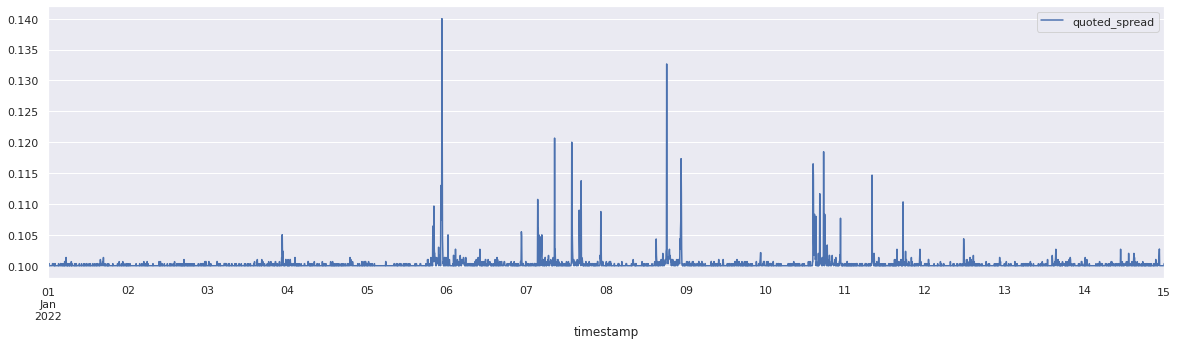

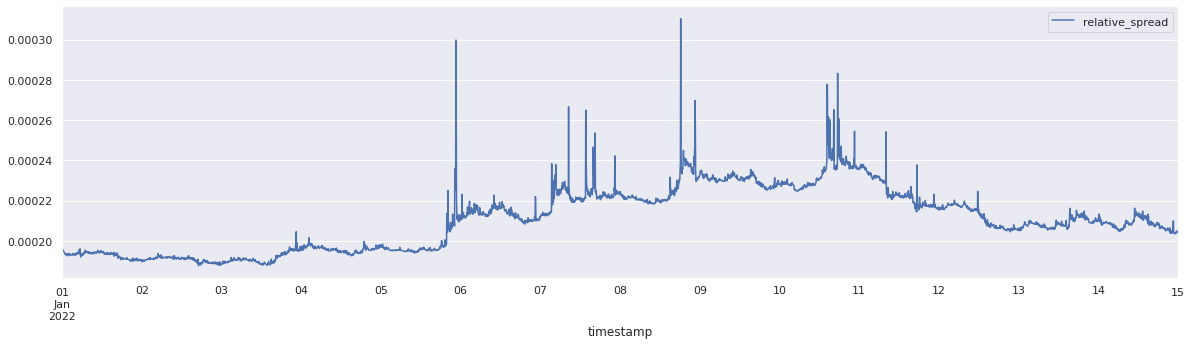

In [48]:
# Metrics visualizations.
final_df.swaplevel(axis=1)["binance::BNB_USDT"][["quoted_spread"]].plot()
final_df.swaplevel(axis=1)["binance::BNB_USDT"][["relative_spread"]].plot()

## Compute the distribution of (return - spread)

In [49]:
# Choose the specific `full_symbol`.
df_bnb = final_df.swaplevel(axis=1)["binance::BNB_USDT"]
df_bnb.head(3)

,close.ret_0,twap.ret_0,vwap.ret_0,close,twap,volume,vwap,ask_value,bid_value,centered_order_book_imbalance,geometric_mid,log_order_book_imbalance,log_relative_spread,mid,mid_value,order_book_imbalance,quoted_spread,relative_spread,weighted_mid,ask_price,ask_size,bid_price,bid_size
timestamp,,,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,NaN,NaN,NaN,512.2,512.20,423.922,512.200000,9.816197e+03,5.121518e+04,0.678376,511.449998,1.652198,0.000196,511.450000,3.051569e+04,0.839188,0.100000,0.000196,511.483919,511.500000,19.191,511.40000,100.147
2022-01-01 00:05:00+00:00,0.002733,0.001952,0.001984,513.6,513.20,2393.343,513.216045,9.303849e+06,8.933841e+06,-0.020190,512.720536,-0.040386,0.000196,512.720539,9.118845e+06,0.489905,0.100337,0.000196,512.719526,512.770707,18144.268,512.67037,17426.092
2022-01-01 00:10:00+00:00,0.000000,0.000624,0.000720,513.6,513.52,1433.895,513.585325,1.194030e+07,8.715529e+06,-0.156024,513.345957,-0.314618,0.000195,513.345960,1.032791e+07,0.421988,0.100000,0.000195,513.338158,513.395960,23257.482,513.29596,16979.540


In [50]:
# Calculate (|returns| - spread) and display descriptive stats.
df_bnb["ret_spr_diff"] = abs(df_bnb["close.ret_0"]) - df_bnb["quoted_spread"]
display(df_bnb["ret_spr_diff"].describe())

count    4032.000000
mean       -0.098863
std         0.001628
min        -0.130807
25%        -0.099695
50%        -0.099131
75%        -0.098339
max        -0.071288
Name: ret_spr_diff, dtype: float64

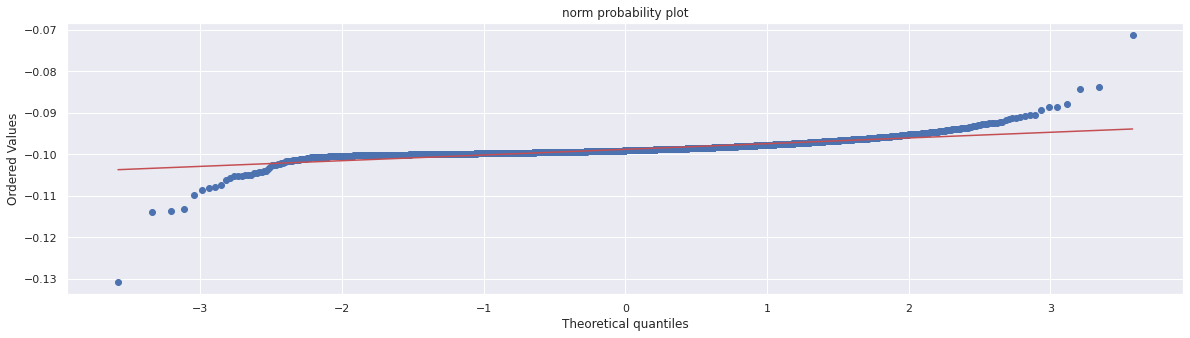

In [51]:
# Visualize the result
cplonorm.plot_qq(df_bnb["ret_spr_diff"])